In [36]:
import torch
import matplotlib.pyplot as plt
import networkx as nx
# local
import sys
if '..' not in sys.path:
    sys.path.insert(0, '..')

from datasets.import_dataset import import_dataset
from trainer import Trainer
from utils.plotting import *
from utils import utils
import datasets.simulations as sim
import link_prediction as lp

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device = {device}')


%load_ext autoreload
%autoreload 2

device = cuda
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# densification for link prediction: take a subgraph that is not
# link prediction: i know some of the nodes and a bunch is dyads on which i need to predict. so take a subgraph 
# so do a densification on all of the edges you have and omitted dyads are the same

#densification. need to do a special densification here. separate between 1 and 0 after the dyads were omitted. so the dyads omittion needs to happen before the densification which makes everything ugly. why does the dyads omittion happen when it does? i think that the m




/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:307:::  
 2024-09-17 12:27:53 starting optimization of pclam on photo on device cuda

 configs_dict: 
{
    "clamiter_init": {
        "dim_feat": 20,
        "dim_attr": 100,
        "s_reg": 0.0,
        "l1_reg": 1,
        "T": 1,
        "hidden_dim": 64,
        "num_coupling_blocks": 32,
        "num_layers_mlp": 2
    },
    "feat_opt": {
        "lr": 1e-05,
        "n_iter": 100,
        "early_stop": 0
    },
    "prior_opt": {
        "n_iter": 1000,
        "lr": 1e-05,
        "noise_amp": 0.05,
        "weight_decay": 0.1,
        "early_stop": 0
    },
    "back_forth": {
        "n_back_forth": 5,
        "scheduler_step_size": 1,
        "scheduler_gamma": 0.5,
        "early_stop_fit": 0,
        "first_func_in_fit": "fit_prior"
    }
}


/home/user/Documents/danny/AAAI_pieclam/experiments/../clamiter.py:550:::  
in fit,
first_func_in_fit='fit_prior'
second_function_name='fit_feats'


/home/user/Docu

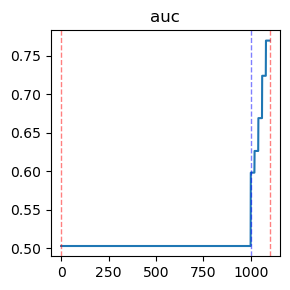



/home/user/Documents/danny/AAAI_pieclam/experiments/../clamiter.py:610:::  
back and forth 2/5


/home/user/Documents/danny/AAAI_pieclam/experiments/../clamiter.py:668:::  
fit, plotting state at iter 2.
dataset: photo, ,model: pclam


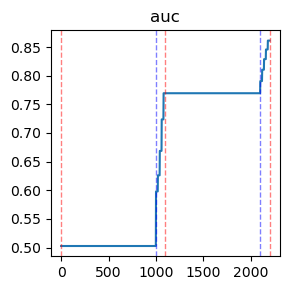



/home/user/Documents/danny/AAAI_pieclam/experiments/../clamiter.py:610:::  
back and forth 3/5


/home/user/Documents/danny/AAAI_pieclam/experiments/../clamiter.py:668:::  
fit, plotting state at iter 3.
dataset: photo, ,model: pclam


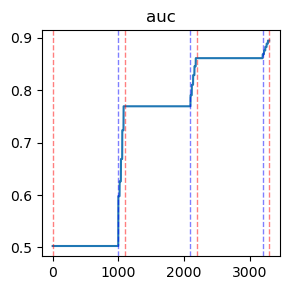



/home/user/Documents/danny/AAAI_pieclam/experiments/../clamiter.py:610:::  
back and forth 4/5


/home/user/Documents/danny/AAAI_pieclam/experiments/../clamiter.py:668:::  
fit, plotting state at iter 4.
dataset: photo, ,model: pclam


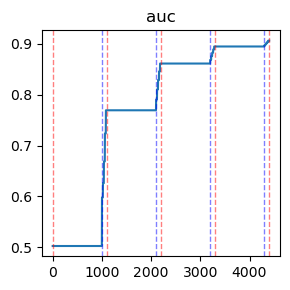



/home/user/Documents/danny/AAAI_pieclam/experiments/../clamiter.py:610:::  
back and forth 5/5


/home/user/Documents/danny/AAAI_pieclam/experiments/../clamiter.py:668:::  
fit, plotting state at iter 5.
dataset: photo, ,model: pclam


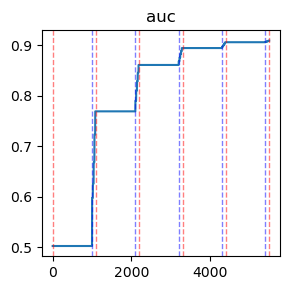



/home/user/Documents/danny/AAAI_pieclam/experiments/../clamiter.py:674:::  
fit end, no early stopping


/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:424:::  


FINISHED train 
 last accuracies:
auc: 0.9095563828731233


/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:430:::  





In [46]:
# train = 85% val = 5% test = 10%
# need to omit 15% of the nodes, then run accuracy on the 5% validation set

#todo: try the minimal neighborhoods init
photo_ds = import_dataset('photo')
photo_ds.edge_index.shape
dyads_to_omit = lp.get_dyads_to_omit(photo_ds.edge_index, 0.1)


# todo: move link prediction functions to link prediction .py file
# todo: make densification
# how to make densification? will have to do it before the trainer stuff to avoid shit.
# 1. from the edges in dyads to omit get the new edge index and densify
# 2. make a new edge attr list the length it's supposed to be.
# 3. unify the edges 
#todo: refactor acctracke
#todo: anomaly detection before the algorithm. what to do with the anomalous nodes

config_triplets = [
    # ['feat_opt', 'lr', 0.000001],
    # ['prior_opt', 'lr', 0.000001],
    ['back_forth','n_back_forth', 5]
                   ]

trainer_photo_ieclam = Trainer(
                        dataset=photo_ds,
                        model_name='pclam',
                        task='link_prediction',
                        config_triplets_to_change=config_triplets,
                        attr_opt=True,
                        device=device,
)

losses, acc_test, acc_val = trainer_photo_ieclam.train(
            init_type='small_gaus',
            init_feats=True,
            dyads_to_omit=dyads_to_omit,
            val_rel_size=0.0,
            acc_every=20,
            plot_every=1,
            verbose=False,
            verbose_in_funcs=False
        )


In [7]:
acc_test['auc'][-1]
# max(acc_test['auc'])

0.957783663587745